
# WCF AI Hands-On Lab: Claims Analytics & Fraud Detection

This Colab notebook is designed for a 1‑day training with the Workers Compensation Fund (WCF) tech team.
You'll work with an anonymized **WCF‑style sample dataset** and (optionally) the Kaggle **“Easy Peasy – Predict Worker Compensation Claims”** dataset.

**Objectives**
- Explore, clean, and visualize claims data.
- Detect anomalies (potential fraud) using an unsupervised model.
- Summarize injury text fields.
- (Optional) Load and compare with the Kaggle *Easy Peasy* dataset.


In [4]:

#@title Install and import libraries
#!pip -q install pandas scikit-learn matplotlib nltk kaggle --upgrade

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import nltk
import os
nltk.download('punkt')
print("Setup complete.")

Setup complete.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aronkondoro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



## 1) Load the WCF-style Sample Dataset

**Option A (Upload):** Download the CSV from the training resources, then upload here.  
**Option B (Google Drive):** Place the CSV in your Drive and load via path.

> File name: `wcf_sample_claims.csv`


In [5]:
# Try local dataset path first (relative to the notebook's working directory)
local_dataset_dir = os.path.join(os.getcwd(), "datasets")
local_csv_path = os.path.join(local_dataset_dir, "synthetic_sample_claims.csv")
    
# Fallback: absolute path to the repo dataset folder (if running from a subdir)
repo_root = "/Users/aronkondoro/Library/Mobile Documents/com~apple~CloudDocs/Projects/WCF"
fallback_csv_path = os.path.join(repo_root, "dataset", "synthetic_sample_claims.csv")

csv_path = local_csv_path if os.path.exists(local_csv_path) else fallback_csv_path
print(f"Loading CSV from: {csv_path}")

df = pd.read_csv(csv_path, parse_dates=["Date_Filed"]) 
df.head()

Loading CSV from: /Users/aronkondoro/Library/Mobile Documents/com~apple~CloudDocs/Projects/WCF/datasets/synthetic_sample_claims.csv


,Claim_ID,Date_Filed,Region,Sector,Employer_Size,Channel,Claim_Type,Injured_Gender,Injury_Type,Age,Claim_Amount_TZS,Processing_Time_Days,Injury_Description,Suspected_Fraud,Claim_Status,Paid_Amount_TZS
0,WCF2022-00001,2021-04-08,Kilimanjaro,Agriculture,Large,Walk-in,Fatality,Male,Amputation,27,2642627,137,Incident involved amputation during loading/un...,0,Approved,2638599
1,WCF2024-00002,2023-04-28,Dodoma,Agriculture,Small,Online Portal,Medical Only,Female,Laceration,39,404552,24,Worker suffered a laceration while operating e...,0,Approved,369800
2,WCF2023-00003,2022-12-18,Mtwara,Construction,Small,Walk-in,Medical Only,Female,Concussion,27,497479,18,Reported concussion due to slip and fall in th...,0,Approved,468173
3,WCF2023-00004,2022-04-26,Mtwara,Mining,Micro,Employer Submission,Medical Only,Male,Fracture,22,226753,16,Claim notes indicate fracture with moderate se...,0,Approved,223881
4,WCF2023-00005,2022-04-20,Dodoma,Public Admin,Small,Walk-in,Medical Only,Female,Sprain/Strain,31,450381,18,Incident involved sprain/strain during loading...,0,Approved,445898



## 2) Quick Exploration


In [6]:

df.info()
display(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Claim_ID              600 non-null    object        
 1   Date_Filed            600 non-null    datetime64[ns]
 2   Region                600 non-null    object        
 3   Sector                600 non-null    object        
 4   Employer_Size         600 non-null    object        
 5   Channel               600 non-null    object        
 6   Claim_Type            600 non-null    object        
 7   Injured_Gender        600 non-null    object        
 8   Injury_Type           600 non-null    object        
 9   Age                   600 non-null    int64         
 10  Claim_Amount_TZS      600 non-null    int64         
 11  Processing_Time_Days  600 non-null    int64         
 12  Injury_Description    600 non-null    object        
 13  Suspected_Fraud     

,Claim_ID,Date_Filed,Region,Sector,Employer_Size,Channel,Claim_Type,Injured_Gender,Injury_Type,Age,Claim_Amount_TZS,Processing_Time_Days,Injury_Description,Suspected_Fraud,Claim_Status,Paid_Amount_TZS
count,600,600,600,600,600,600,600,600,600,600.000000,6.000000e+02,600.000000,600,600.000000,600,6.000000e+02
unique,600,NaN,10,10,4,4,4,2,10,NaN,NaN,NaN,317,NaN,4,NaN
top,WCF2022-00001,NaN,Kilimanjaro,Mining,Small,Walk-in,Medical Only,Male,Laceration,NaN,NaN,NaN,Incident involved concussion during loading/un...,NaN,Approved,NaN
freq,1,NaN,68,137,184,224,325,431,76,NaN,NaN,NaN,7,NaN,409,NaN
mean,NaN,2022-07-02 11:45:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.746667,7.388469e+05,33.386667,NaN,0.015000,NaN,5.494758e+05
min,NaN,2021-01-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,1.000000e+05,3.000000,NaN,0.000000,NaN,0.000000e+00
25%,NaN,2021-09-28 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.000000,3.609965e+05,18.000000,NaN,0.000000,NaN,1.403160e+05
50%,NaN,2022-06-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.000000,6.156110e+05,24.000000,NaN,0.000000,NaN,4.349285e+05
75%,NaN,2023-04-14 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,9.005845e+05,37.000000,NaN,0.000000,NaN,7.576250e+05
max,NaN,2023-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,7.274465e+06,176.000000,NaN,1.000000,NaN,4.438758e+06


In [7]:

df['Suspected_Fraud'].value_counts(normalize=True).rename('share').to_frame()

,share
Suspected_Fraud,
0,0.985
1,0.015



## 3) Visualize Claims


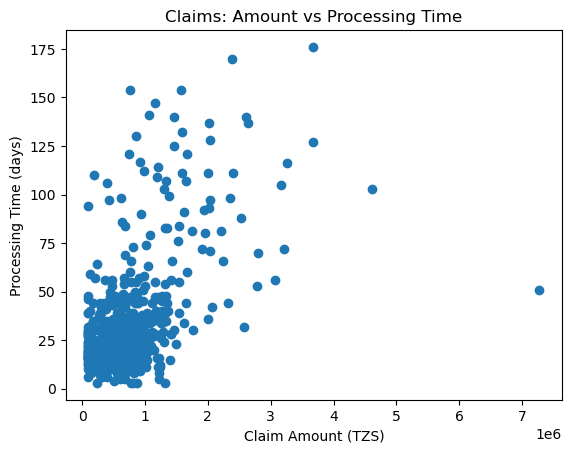

In [8]:

plt.figure()
plt.scatter(df['Claim_Amount_TZS'], df['Processing_Time_Days'])
plt.xlabel("Claim Amount (TZS)")
plt.ylabel("Processing Time (days)")
plt.title("Claims: Amount vs Processing Time")
plt.show()

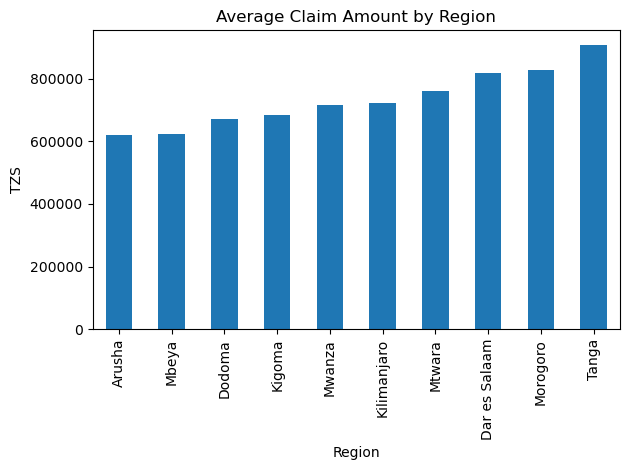

In [9]:

plt.figure()
df.groupby('Region')['Claim_Amount_TZS'].mean().sort_values().plot(kind='bar')
plt.title("Average Claim Amount by Region")
plt.ylabel("TZS")
plt.tight_layout()
plt.show()


## 4) Anomaly Detection (Unsupervised)
We'll use **IsolationForest** on numerical features to flag potentially unusual claims.


In [10]:

features = df[['Claim_Amount_TZS', 'Processing_Time_Days', 'Age']].copy()
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)

outliers = df[df['anomaly'] == -1]
print(f"Flagged {len(outliers)} / {len(df)} claims as unusual (~{len(outliers)/len(df):.1%}).")
outliers[['Claim_ID','Claim_Amount_TZS','Processing_Time_Days','Sector','Channel','Suspected_Fraud']].head(10)

Flagged 30 / 600 claims as unusual (~5.0%).


,Claim_ID,Claim_Amount_TZS,Processing_Time_Days,Sector,Channel,Suspected_Fraud
0,WCF2022-00001,2642627,137,Agriculture,Walk-in,0
50,WCF2024-00051,1069598,141,Mining,Walk-in,0
54,WCF2023-00055,2800139,70,Retail,Walk-in,0
56,WCF2023-00057,1323468,54,Agriculture,Employer Submission,0
62,WCF2023-00063,764526,154,Mining,Employer Submission,0
67,WCF2023-00068,3062933,56,Agriculture,Walk-in,0
87,WCF2022-00088,743677,121,Manufacturing,Employer Submission,0
106,WCF2024-00107,3161281,105,Transport,Walk-in,0
129,WCF2023-00130,3674874,176,Public Admin,Online Portal,0
158,WCF2023-00159,3211870,72,Public Admin,Employer Submission,0


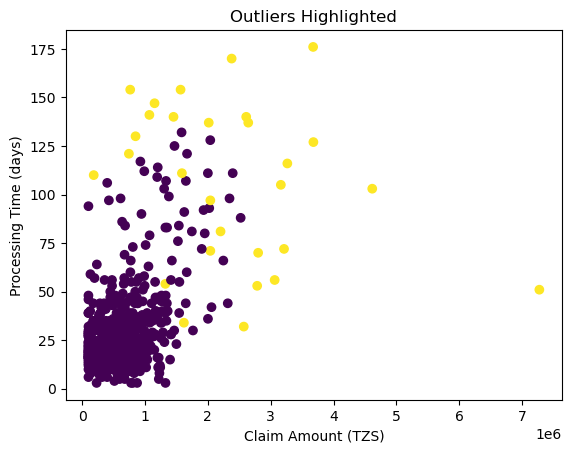

In [11]:
plt.figure()
plt.scatter(df['Claim_Amount_TZS'], df['Processing_Time_Days'], c=(df['anomaly']==-1).astype(int))
plt.xlabel("Claim Amount (TZS)")
plt.ylabel("Processing Time (days)")
plt.title("Outliers Highlighted")
plt.show()


## 5) Quick Text Summaries (NLP)


In [12]:

from nltk.tokenize import sent_tokenize

def summarize_text(text):
    sents = sent_tokenize(text or "")
    return sents[0] if sents else ""

df['Summary'] = df['Injury_Description'].apply(summarize_text)
df[['Claim_ID','Injury_Description','Summary']].head(5)

,Claim_ID,Injury_Description,Summary
0,WCF2022-00001,Incident involved amputation during loading/un...,Incident involved amputation during loading/un...
1,WCF2024-00002,Worker suffered a laceration while operating e...,Worker suffered a laceration while operating e...
2,WCF2023-00003,Reported concussion due to slip and fall in th...,Reported concussion due to slip and fall in th...
3,WCF2023-00004,Claim notes indicate fracture with moderate se...,Claim notes indicate fracture with moderate se...
4,WCF2023-00005,Incident involved sprain/strain during loading...,Incident involved sprain/strain during loading...



## 6) (Optional) Load the Kaggle **“Easy Peasy – Predict Worker Compensation Claims”** Dataset

**One-time setup in Colab:**
1. Create a Kaggle account, then go to *Account → API → Create New Token*. This downloads `kaggle.json`.
2. Upload `kaggle.json` to Colab (left sidebar → files).
3. Run the cell below to place it at `~/.kaggle/kaggle.json` and download the dataset.

> Dataset slug: `lucamassaron/easy-peasy-its-lemon-squeezy`


In [ ]:

#@title Kaggle API setup (run after uploading kaggle.json)
import os, shutil, zipfile, glob

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
if os.path.exists("/content/kaggle.json"):
    shutil.move("/content/kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!kaggle datasets download -d lucamassaron/easy-peasy-its-lemon-squeezy -p /content/easy_peasy -q
# Unzip
for z in glob.glob("/content/easy_peasy/*.zip"):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("/content/easy_peasy")
print("Easy Peasy dataset ready at /content/easy_peasy")


In [ ]:

# List files to identify CSVs to load
import os

for root, dirs, files in os.walk("/content/easy_peasy"):
    for f in files:
        if f.lower().endswith(".csv"):
            print(os.path.join(root, f))

# Example usage:
# easy_df = pd.read_csv("/content/easy_peasy/<replace_with_csv_name>.csv")
# easy_df.head()



## 7) Next Steps
- Discuss which additional fields (e.g., diagnosis codes, employer compliance history) would improve detection.
- Draft a WCF pilot plan: data access, success metrics, integration points, and governance.
